# Small Tour Into Imaging

Among other, we will learn:

 - **Linear algebra** is ubiquitous in imaging (and signal processing in general)
 - **convolution**/**filter**, **Toeplitz** matrix, **Kronecker** product, **flattening**, **padding**/boundary conditions
 - We need **sparse formats** to deal with high-dimensional image data
 - **Iterative methods** to approximate solutions
 - Application: **Image inpainting**

**Motivation**

Suppose you find yourself in the following situation: 

Some bytes and bits of your favourite photo have been corrupted (set to zero) and the image now looks like this:

<img src="./media/kalle_firstapproach.png" width="600"/>

Let the resolution be $H \times W$ (= shape of the image) and assume you can measure, which pixels are precisely lost in the image. 

What could you do to reconstruct your original image?

Let's apply our toolbox:

 - We are given some noisy image $b\in\mathbb{R}^n$ (flattened, $n=HW$)
 - We are looking for the original, high-resolution image $x \in \mathbb{R}^n$
 - We know the linear distortion operator $A \in \mathbb{R}^{n \times n}$, which has set some pixels to zero and produced $$b = Ax.$$ This $A$ is obtained from the identity matrix by setting the diagonal entries to zero where the pixels are lost.


We could try to recover the original image from solving this equation. Would this be a good idea?

No! Because taking $b$ and setting the lost pixels to any color value would be a solution here. 

In fact, the problem is ill-posed (existence, but not uniqueness)!

One solution would be $Ab =b.$ (Observe that $A$ is an orthogonal projector, therefore $A^2 = A$)

<img src="kalle_firstapproach.png" width="400"/>

Well, we could formulate a least squares problem:

$$\min_x \|Ax-b\|_2^2$$

Is this better now?

No, because we have just found an $x$ which solves the equation exactly. 

And this solution $x=b$ is precisely the minimum-norm least squares solution, i.e., we just get back our noisy image $b$.


Any other ideas?

What about Tikhonov regularization?

$$\min_x \|Ax-b\|_2^2 + \frac{\delta}{2}\|x\|^2_2.$$

Better?

With the $A$ from above ($A^\top = A, Ab=b$) the system

$$(A^\top A + \delta I)x = A^\top b $$

is equivalent to this diagonal system

$$(A + \delta I)x = b .$$

The solution $x=x_\delta$ is thus given by

$$x_i = 
\begin{cases}
\frac{b_i}{1+\delta}&: \text{known pixel}\\
\frac{b_i}{\delta}&: \text{lost pixel}
\end{cases}
= 
\begin{cases}
\frac{b_i}{1+\delta}&: \text{known pixel}\\
0&: \text{lost pixel}
\end{cases}
$$

This is also not going to bring us any further. 

However a regularized least squares problem is the right direction:

$$\min_x \|Ax-b\|_2^2 + \frac{\delta}{2}\|Dx\|_2^2.$$



The problem with Tikohonov regularization ($D=I$) is that it only considers local information.


Improvement in the example later on:
- We will define $D$ in such a way that it penalizes huge differences between neighboring pixels.
- Thereby information from the direct neighbors will we be considered in the optimization problem.

This is referred to Sobolev regularization and the result may look like this

<img src="./media/intro_kalle_solved.png" width="1200"/>

... not too bad!

The outline:

 - Generalizing Tikhonov Regularization
 - Working with images: Flattening, filters (1d, 2d),...
 - Worked Example: Inpainting

## Generalizing Tikhonov Regularization

We have slightly modified the Tikhonov regularization term by allowing linear transformations before the norm is evaluated. For some matrix $D \in \mathbb{R}^{p \times n}$, consider

$$\min_x \|Ax-b\|_2^2 + \frac{\delta}{2}\|Dx\|_2^2.$$


The necessary first--order optimality conditions then read as

\begin{equation}\label{eq:regularized_normaleq}
(A^\top A + \delta D^\top D) x = A^\top b. 
\end{equation}



 - Problems of this nature are also called *inverse problems*, as we go inverse from the measured data (here $b$) to the original parameters, which have produced these measurements but are not directly observable.
 - Different choices of distortion operators $A$ lead to different applications: Inpainting (here), super-resolution, sub-sampling, ...

 More remarks:
 
 $$\min_x \|Ax-b\|_2^2 + \tfrac{\delta}{2}\|Dx\|_2^2$$
 
 - The first term in the objective is of matching-type and makes sure that the recovered data has something to do with the measurements.
 - The regularization term, here $\frac{\delta}{2}\|Dx\|_2^2$, is sometimes referred to as *prior* and is used to prescribe desired (smoothness) properties for the solution and thus assumes *prior* knowledge on the kind of data one expects to restore.
   - For example: If $D$ evaluates the differences between neighboring pixels, then by increasing $\delta$, these have to become small in order to minimize this part of the objective function.

 - For appropriate choices of $D$ (examples below), we obtain a well-posed problem.
 - Observe that for $D = I$ we obtain the standard Tikhonov (or $L^2$-) regularization. 

## Working with Images

- We look at some basics and avoid the usage of preimplemented libraries to understand the underlying concepts.

- How are images stored in a computer? <img src="media/image.png" width="1200"/>

   - take a regular squared grid
   - for each square in the grid we store a number (or triple of numbers) which represents a color
   - the more squares (picture elements) the higher the resolution and storage demand
   - all in all, this results in a table of numbers (or more tables)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import ipywidgets as widgets
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

---
Type: <class 'numpy.ndarray'>
Dimension/Resolution: (960, 1048)
---


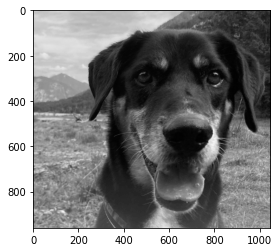

In [2]:
path_to_img = "media/kalle.jpg"
img = np.array(Image.open(path_to_img).convert("L"))
print("---\nType: {typ}\nDimension/Resolution: {dim}\n---".format(typ=type(img), dim=img.shape))
plt.imshow(img, cmap="gray")

Having the image loaded as a numpy array is very powerful and allows any sort of array manipulation!

*(Pointwise functions explained on the blackboard)*

In [3]:
def lighten(img, percent):
    # convex combination with 1's
    return (1 - percent) * img +  percent * (255 * np.ones(img.shape))

@widgets.interact_manual(percent=(0.0, 1.0))
def plot(percent=0):
    plt.imshow(lighten(img.copy(), percent), cmap="gray", vmin=0, vmax=255)

interactive(children=(FloatSlider(value=0.0, description='percent', max=1.0), Button(description='Run Interact…

interactive(children=(FloatSlider(value=0.1, description='percent', max=1.0, min=0.1), Button(description='Run…

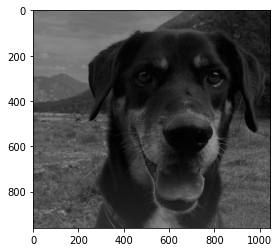

In [4]:
def darken(img, percent):
    # convex combination with 0's
    return (1-percent)*img

@widgets.interact_manual(percent=(0.1, 1.0))
def plot(percent=0):
    plt.imshow(darken(img.copy(),percent), cmap="gray", vmin=0, vmax=255)

interactive(children=(FloatSlider(value=0.0, description='brightness_factor', max=1.0, min=-1.0), Button(descr…

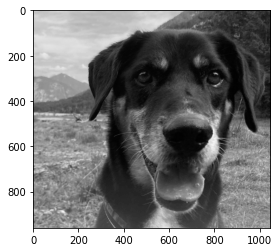

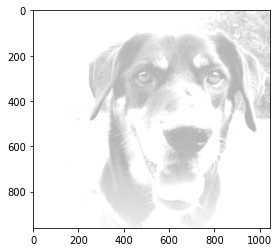

In [5]:
def brightness(img, brightness_factor):
    # shift by a constant and project on (0,255)
    img = img + brightness_factor * 255. * np.ones(img.shape)
    img[img > 255] = 255
    img[img < 0] = 0
    return img.astype("int")

@widgets.interact_manual(brightness_factor=(-1.0, 1.0))
def plot(brightness_factor=0):
    plt.imshow(brightness(img.copy(),brightness_factor), cmap="gray", vmin=0, vmax=255)

interactive(children=(Dropdown(description='direction', options=('lr', 'ud'), value='lr'), Button(description=…

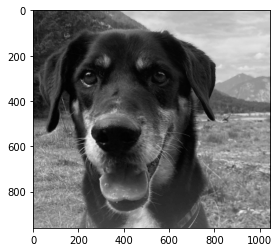

In [6]:
def flip(img, direction= "lr"):
    if direction == "lr":
        return np.fliplr(img)
    else:
        return np.flipud(img)

@widgets.interact_manual(direction=["lr", "ud"])
def plot(direction=0):
    plt.imshow(flip(img.copy(), direction), cmap="gray", vmin=0, vmax=255)

interactive(children=(IntSlider(value=0, description='lower_threshold', max=255), IntSlider(value=0, descripti…

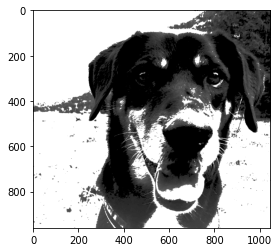

In [7]:
def contrast(img, lower_threshold="122", upper_threshold="122"):
    img[img < lower_threshold] = 0  # black
    img[img >= upper_threshold] = 255  # white
    return img

@widgets.interact_manual(lower_threshold=(0, 255), upper_threshold=(0, 255))
def plot(lower_threshold=0, upper_threshold=0):
    plt.imshow(contrast(img.copy(), lower_threshold, upper_threshold), cmap="gray", vmin=0, vmax=255)

## Flattening
- For applying linear transformations to the image, like computing local averages, it is convenient to flatten the image (2d data) into a vector (1d data). 
- Linear transformations of the image then become matrix-vector products.

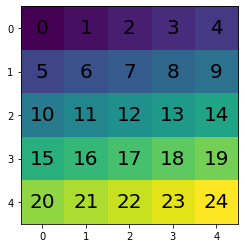

In [8]:
%matplotlib inline
n = 5
b = np.arange(0, n**2, 1, dtype="int").reshape(n,n)

plt.imshow(b)
for (j,i),label in np.ndenumerate(b):
    plt.text(i, j, label, ha='center', va='center', fontsize=20)

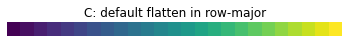

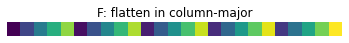

In [9]:
for order, title in zip(['C', 'F'], ["C: default flatten in row-major", "F: flatten in column-major"]):
    b_flat = b.reshape(1,n**2,order=order)
    plt.figure(), plt.imshow(b_flat, interpolation="nearest"), plt.title(title), plt.axis(False)

*Blackboard:*

**Mathematically**: Let $m$ and $n$ be height and width, respectively.

Let $b \in \mathbb{R}^{m \times n}$ and $\text{vec}(b) \in\mathbb{R}^{mn}$ be the flattened version of $b$. 

If row-major order is applied, then the index map from matrix to vector is given by
$$b(i,j) =  \text{vec}(b)(i\cdot n + j),~~0\leq i \leq m-1,~ 0\leq j \leq n-1, $$
and from vector to matrix by
$$\text{vec}(b)(k) =  b(k // n, k \%n),~~0\leq k \leq mn-1.$$

## Translationally Invariant Filters 

The important keywords:

 - **convolution**/**filter** 
 - (two-level) **Toeplitz** matrix
 - separable 2d filter = **Kronecker** product of 1d filter (=one-level Toeplitz)
 - **padding**/boundary conditions (particularly for more nonlocal filters)

### 1d Introductory Example 

Assume we have a discrete 1d signal, i.e., a vector `signal` $\in \mathbb{R}^n$

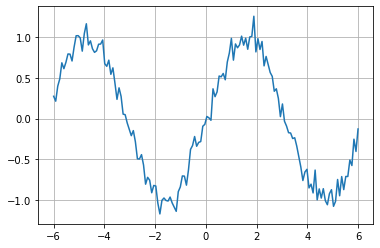

In [10]:
import numpy as np
import matplotlib.pyplot as plt
n = 150
noise = 0.1
x = np.linspace(-6,6,n) 
signal = np.sin(x) + np.random.normal(0, noise, n)
plt.plot(x, signal)
plt.grid()

Now we would like to transform this 1d signal into a new vector, say `signal_filtered` $\in \mathbb{R}^n$, by applying a *moving* average of size $k$, so that formally for the interior points

$$\text{signal_filtered}(i) := \frac{1}{n}\sum_{j=i-k//2}^{i+k//2} \texttt{signal}(j)$$

This corresponds to the 1d average filter

$$\frac{1}{n} [1,1,\cdots,1].$$

*Blackboard:*

Let us translate this operation into a matrix-vector product

 - Padding to deal with boundary points.
 - Derive Toeplitz matrix.

In [11]:
def average_1d(horizon):
    return [1./horizon] * horizon

def filter_matrix_1d(weights, dim, normalize=1):
    import numpy as np
    import scipy.linalg as linalg
    import scipy.sparse as sparse
    kernel_horizon = len(weights)
    row = np.append(weights, np.zeros(dim - kernel_horizon))
    if normalize:
        row *= 1./ np.sum(row)
    col = np.zeros(dim)
    col[0] = row[0]
    A = linalg.toeplitz(col, row) 
    A = sparse.csr_matrix(A)
    return A

signal_padded[0:3] = [0.21447582 0.27475548 0.21447582]


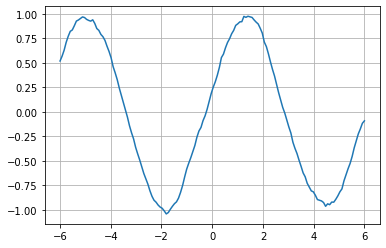

In [12]:
signal_padded = np.pad(signal, 1, mode="reflect")  #  constant
print("signal_padded[0:3] =", signal_padded[0:3])
horizon = 10
weights = average_1d(horizon)
A = filter_matrix_1d(weights, len(signal_padded), normalize=0)
signal_filtered = A.dot(signal_padded)
plt.plot(x, signal_filtered[0:-2]) # cropped due to padding
plt.grid()

Observation: The moving average is very good in reducing random noise while retaining the shape of the signal

We say: "convolution smoothens"

### 2d case

Now we want to proceeed in the same fashion and apply a weighted averaging on each pixel:

Average filter:
$$\frac{1}{9}\begin{pmatrix}1&1&1\\1&1&1\\1&1&1\end{pmatrix}= xx^\top ,~~~x = \frac{1}{3}\begin{pmatrix}1\\1\\1\end{pmatrix} $$

Gaussian filter:
$$\frac{1}{16}\begin{pmatrix}1&2&1\\2&4&2\\1&2&1\end{pmatrix} = xx^\top ,~~~x = \frac{1}{4}\begin{pmatrix}1\\2\\1\end{pmatrix}$$

-> translationally invariant (same for each pixel) and separable (rank 1) filter.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
%matplotlib inline

def show_image(matrix, title="", cmap="gray", vmin=0, vmax=1, plot_numbers=False):
    plt.figure()
    plt.title(title)
    plt.imshow(matrix, cmap, vmin=vmin, vmax=vmax)
    if plot_numbers:
        for (j, i), label in np.ndenumerate(matrix):
            plt.text(i, j, np.round(matrix[i, j], 1), ha='center', va='center', fontsize=7)
    return None

**2d filter from 1d filter**

In [1]:
def plot_filter(weights):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(weights, '-')
    plt.axis(False)
    plt.title("1d: x")
    plt.subplot(1, 2, 2)
    plt.imshow(np.outer(weights, weights))
    plt.axis(False)
    plt.title("2d: xx.T")
    plt.show()

In [15]:
def gaussian_1d(sigma, horizon):
    # mu = 0
    g = lambda x: np.exp(- 0.5 * (x / sigma) ** 2) * 1 / (np.sqrt(2 * np.pi) * sigma)
    X = np.linspace(- (horizon // 2), horizon // 2, horizon, endpoint=True)
    return g(X)

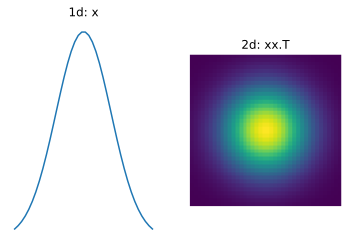

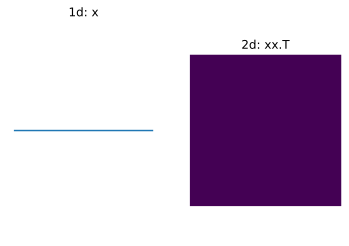

In [16]:
horizon = 40
sigma = 0.2*horizon
plot_filter(gaussian_1d(sigma, horizon))
plot_filter(average_1d(horizon))

**Example Image**

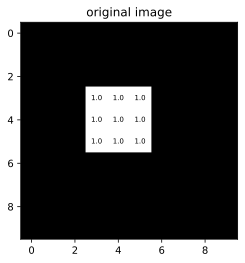

In [17]:
def example_image(n):
    import numpy as np
    img = np.zeros((n,n))
    img[int(0.35*n):int(0.65*n), int(0.35*n):int(0.65*n)] = 1
    return img

n = 10
b = example_image(n)
show_image(b, "original image", plot_numbers=1)

**Padding with `numpy.pad`**

How to compute the average for the boundary pixels?

One common approach is to extend the image with an artificial "nonlocal boundary". 

Again, we use `numpy.pad`: https://numpy.org/doc/stable/reference/generated/numpy.pad.html

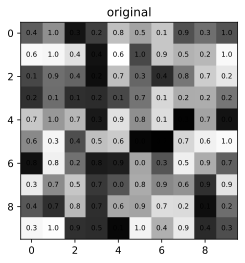

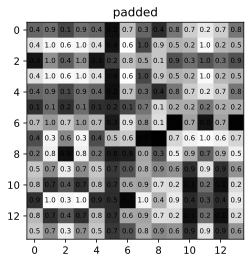

In [18]:
horizon = 4
pad_width = horizon // 2
b = np.random.rand(n,n)
b_padded = np.pad(b, pad_width=horizon//2, mode="reflect") # mode = constant, minimum, symmetric, reflect,...
n_padded = n + 2 * pad_width
show_image(b, "original", plot_numbers=1)
show_image(b_padded, "padded", plot_numbers=1)

**Filter Matrix Construction**

For constructing the application of the filter as a matrix-vector product we expect the image to be already padded.

We will not go into detail here and instead recommend Sections IV.3-5 in Strang's book *Linear Algebra and Learning from Data*.

The ideas come from the 1d case.

In [19]:
def filter_matrix_2d(weights, width, normalize=1):
    import scipy.sparse
    A = filter_matrix_1d(weights, width, normalize=1)
    A = scipy.sparse.kron(A, A)
    return A

In [20]:
def apply_filter(b, A, horizon, pad_mode="symmetric"):
    """padding and matrix-vector product"""
    m, n = np.shape(b)
    # pad the original image
    pad_width = horizon // 2
    b_padded = np.pad(b, pad_width=horizon//2, mode=pad_mode)
    n_padded = n + 2 * pad_width
    b_padded_flat = b_padded.reshape(n_padded ** 2,1)
    # apply filter and de-pad
    b_padded_flat_filtered = A.dot(b_padded_flat)
    b_padded_filtered = b_padded_flat_filtered.reshape(n_padded, n_padded, order="C")
    b_filtered = b_padded_filtered[0:n, 0:n]  # explain
    b_filtered_flat = b_filtered.reshape(n**2, 1)
    return b_filtered

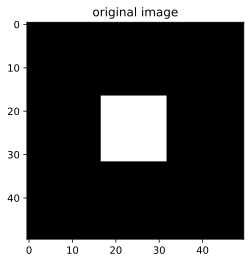

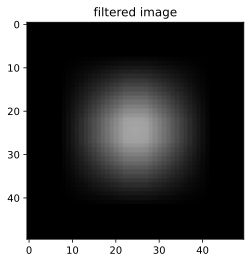

In [21]:
n = 50  # 50
horizon = 20  # 10
plot_numbers = True 
b = example_image(n)   # np.random.rand(n,n)  #  
weights = gaussian_1d(10, horizon)  # average_1d(horizon)  # 
A = filter_matrix_2d(weights, n + 2 * (horizon // 2) , normalize=1)
b_filtered = apply_filter(b, A, horizon, pad_mode="symmetric")
show_image(b, "original image", plot_numbers=0)
show_image(b_filtered, "filtered image",plot_numbers=0)

## Worked Example: [Image Inpainting](https://en.wikipedia.org/wiki/Inpainting)

We are given the flattened noisy image $b$, which results from the unknown flattened original image $x$ through the following masking operation
\begin{equation} \label{eq:masking_operation}
 b_i =(Ax)_i = \begin{cases}
x_i & i \in \texttt{indices},\\
0 & \text{else},
\end{cases}
\end{equation}
where $\texttt{indices}$ is a list of random pixels. 

In words, the pixels in $\texttt{indices}$ survived, the rest is lost (set to zero). We want to recover those lost pixels. 

As discussed above, the masking operation can be written as a matrix-vector product
$$b = Ax $$
for some quadratic matrix $A$. 

We will seek for solutions of the regularized least squares problem

$$\min_x \|Ax-b\|_2^2 + \frac{\delta}{2}\|Dx\|_2^2.$$

by solving

$$
(A^\top A + \delta D^\top D) x = A^\top b. 
$$

For this purpose will choose a particular $D$ which is related to Sobolev (or $H^1$-) regularization (details below). 

**Outline**

 - implement function `A = masking_matrix(image_shape, percentage)`
 - implement function `D = difference_matrix(image_shape)`
 - implement function `b = distortion(A, img)` (to obtain test data $b$)
 - implement function `x = reg_lstsq(A, b, D, reg_param=0.1)` to solve the regularized normal equation
 - plot the results and play around with the parameters
 
 
 - Due to the high dimensional image data ($n = HW$!) we need to work with *sparse* matrices. Also, we will apply iterative methods which only require matrix-vector products and potentially few iterations.

**Masking: `A = masking_matrix(image_shape, percentage)`** 

`percentage` in (0,1) indicates the percentage of pixels that are randomly kept. 

The sparse  $(n \times n)$ masking matrix $A$ is zero everywhere except for $a_{ii} = 1$ for $i \in$`indices`


In [22]:
def masking_matrix(image_shape, percentage):
    """Randomly sets (1-percentage)*100 % of the pixels to zero, i.e.
    percentage*100% of the pixels are kept"""
    import numpy as np
    import scipy.sparse as sparse
    dim = np.prod(image_shape)    
    if percentage == "patch":
        #patch_size = int(0.1 * dim)
        #H, W = image_shape
        #indices = [i * W + j for i in range(patch_size, 2*patch_size) for j in range(patch_size,2*patch_size)]
        pass
    else:
        indices = np.random.choice(np.arange(dim), replace=False, size=int(dim * percentage))
    A = sparse.coo_matrix((np.ones(len(indices)),
                           (indices, indices)), shape=(dim, dim)).tocsr()
    A = A.tocsr()
    return A

In [23]:
def test_masking_matrix(image_shape, percentage):
    import numpy as np
    A = masking_matrix(image_shape, percentage)
    dim = np.prod(image_shape) 
    assert A.shape == (dim, dim), "masking matrix has wrong dimension"
    assert A.data.size == int(dim * percentage), "masking matrix has more nonzeroes than expected"
    assert A.data == [1] * int(dim * percentage), "masking matrix has other nonzeroes than 1's"
    assert (A.T - A).data.size == 0, "masking matrix not symmetric"
    assert (A @ A - A).data.size == 0, "masking matrix not idempotent"
test_masking_matrix((3,4), 0.1)

**Regularization: `D = difference_matrix(image_shape)`**

 - Develop on blackboard for simple 2x3 example.
 - Idea
   - We want to use "nonlocal" information from direct neighbors.
   - More precisely, we will penalize differences between horizontal and vertical neighbors (five-point stencil)
   - We can think of it as incidence matrix of a graph: Let image be of size $H \times W$
     - horizontal differences/edges = $H(W-1)$
     - vertical differences/edges = $(H-1)W$
     - total number of edges $p = 2HW - H - W$
     - we encode the nodes belonging to an edges with 1 and -1 
     - all in all the difference matrix is of size $p\times HW$

In [24]:
import numpy as np
H, W = 2, 3
n = H * W
G_horizontal = np.kron(np.eye(H), np.eye(W-1, W, k=0) - np.eye(W-1, W, k=1))
G_vertical = np.kron(np.eye(H-1, H, k=0) - np.eye(H-1, H, k=1), np.eye(W))
G = np.vstack((G_horizontal, G_vertical))
print(G.astype("int"))

[[ 1 -1  0  0  0  0]
 [ 0  1 -1  0  0  0]
 [ 0  0  0  1 -1  0]
 [ 0  0  0  0  1 -1]
 [ 1  0  0 -1  0  0]
 [ 0  1  0  0 -1  0]
 [ 0  0  1  0  0 -1]]


In [25]:
def difference_matrix(image_shape):
    """returns difference matrix D; shape = edges x nodes (graph=squared grid)"""
    import scipy.sparse as sparse
    H, W = image_shape
    n = H * W
    D = sparse.eye(n+1, n, k=0) - sparse.eye(n+1, n, k=-1)
    D_horizontal = sparse.kron(sparse.eye(H), sparse.eye(W-1, W, k=0) - sparse.eye(W-1, W, k=1))
    D_vertical = sparse.kron(sparse.eye(H-1, H, k=0) - sparse.eye(H-1, H, k=1), sparse.eye(W))
    D = sparse.vstack((D_horizontal, D_vertical))
    D = D.tocsr()
    return D

In [26]:
def test_difference_matrix(image_shape):
    D = difference_matrix(image_shape)
    #print(D.toarray().astype("int"))
    H, W = image_shape
    assert D.shape == (2 * H * W - H - W, H * W), "difference matrix has wrong dimension"
test_difference_matrix((3,4))

**Generate test data**

In [27]:
def distortion(distortion_matrix, img):
    """simple matrix vector product"""
    return distortion_matrix.dot(img.ravel())

**Solve regularized Least Squares Problem: `x = reg_lstsq(A, b, D, reg_param=0.1)`**

$$
(A^\top A + \delta D^\top D) x = A^\top b. 
$$

In [28]:
def reg_lstsq(A, b, D, reg_param=0.1, verbose=1):
    """A csr nxn, b vector nx1, D csr pxn, delta float"""
    import scipy.sparse.linalg
    _delta = reg_param
    n = len(b)
    if verbose:
        print("start solving")
    recon_img = scipy.sparse.linalg.gmres(A.T @ A + _delta * D.T @ D, A.T.dot(b), maxiter=1)[0]
    if verbose:
        print("finished solving")
    # scipy.sparse.linalg.spsolve(A.T@A + _delta * D.T@D, A.dot(b))#
    return recon_img

**Experimenting**

In [29]:
def experiment(path_to_image, percentage, reg_param, save=False):
       
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt   
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg')  
    %matplotlib qt
    
    original_img = np.array(Image.open(path_to_image).convert("L"))
    img_shape = np.shape(original_img)
    print("Resolution:", img_shape)
    
    dim = np.prod(img_shape)
    A = masking_matrix(img_shape, percentage)   
    b = distortion(A, original_img).ravel()
    D = difference_matrix(img_shape) 
    recon_img = reg_lstsq(A, b, D, reg_param=reg_param)
   
    plt.figure("Image Inpainting")
    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("original")
    plt.axis(False)

    plt.subplot(1, 3, 2)
    plt.imshow(b.reshape(img_shape), cmap='gray')
    plt.title("masked image: {}% of pixels randomly lost".format((1-percentage)*100))
    plt.axis(False)

    plt.subplot(1, 3, 3)
    plt.imshow(recon_img.reshape(img_shape), cmap='gray')
    plt.axis(False)
    plt.title("reconstructed image: reg-param delta={}".format(reg_param))
    plt.show()
    
    if save:
        plt.savefig("Image_Inpainting", dpi='figure')
        
    return None

Resolution: (960, 1048)
start solving
finished solving


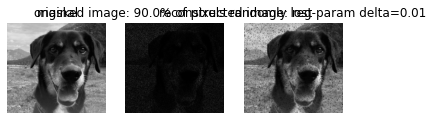

In [31]:
path_to_image = "media/kalle.jpg"
percentage = 0.1  #0.01  # we randomly keep 100*percentage % of the data
reg_param = 0.01  # regularization parameter
save = False
# 
%matplotlib inline
experiment(path_to_image, percentage, reg_param, save)

Play

- Play around with different choices for the parameters `reg_param` and `percentage` as well as `maxiter` for GMRES
- Would your machine cope with dense arrays?
- Patch: Instead of removing randomized set of pixels, remove a patch of the image. Can you reconstruct it?
- Unknown data: Can you define the operator $A$ from given data?